<a href="https://colab.research.google.com/github/PattarapornH/Crab-Molting-Detection/blob/master/Molting_crab_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
path_dir = 'gdrive/My Drive/Year4/Project/top_view/Case10_2018_09_29_Coor(5_2)/'

path = []

for p in os.listdir(path_dir):
  # print(p)
  path.append(p)

# sorted(path)
path[0:10]


['21-20-05.png',
 '21-20-55.png',
 '21-20-15.png',
 '21-20-35.png',
 '21-20-45.png',
 '21-20-25.png',
 '21-21-25.png',
 '21-21-15.png',
 '21-21-05.png',
 '21-21-35.png']

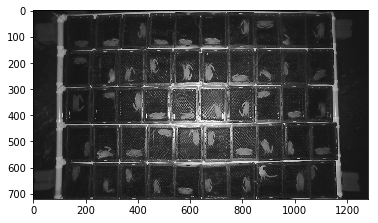

In [31]:
import cv2 as cv

data = []

# for p in path:
#   img = cv.imread()
data.append(cv.imread(path_dir+'/'+path[0]))

# plt.subplot(211)
plt.imshow(data[0]/255)

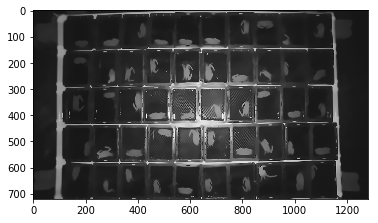

In [49]:
img = cv.fastNlMeansDenoisingColored(data[0],None,10,10,7,21)
plt.imshow(img/255)


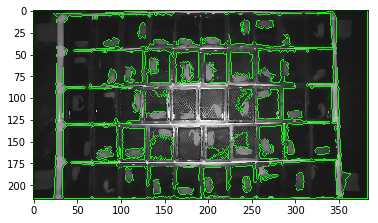

In [50]:

resize = cv.resize(data[0], None, fx=0.3, fy=0.3, interpolation = cv.INTER_CUBIC)
gray = cv.cvtColor(resize, cv.COLOR_BGR2GRAY)
_,thresh = cv.threshold(gray,50,255,cv.THRESH_BINARY_INV)
_, contours, _ = cv.findContours(thresh,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    size = cv.contourArea(cnt)
    if 100 < size < 30000:
        cv.drawContours(resize, [cnt], 0, (0,255,0), 1)

plt.imshow(resize)